In [1]:
import re
import unicodedata
import numpy as np
import pandas as pd
from itertools import product
from IPython.display import display, HTML
import plotly.express as px
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import seaborn as sb
import os
from datetime import datetime, date
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.sarimax import SARIMAXResults
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima

# Scikit
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
from sklearn import metrics

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz
from sklearn import tree

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostClassifier

from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PolynomialFeatures


from sklearn.neighbors import KNeighborsTransformer, KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.base import clone

from sklearn.svm import LinearSVC
from sklearn.svm import SVC

In [2]:
generate_from_scratch = True;

In [3]:
if generate_from_scratch:
    counter = 0
    
    acorn_details = pd.read_csv("data/acorn_details.csv", encoding='unicode_escape')
    informations_households = pd.read_csv("data/informations_households.csv")
    uk_bank_holidays = pd.read_csv("data/uk_bank_holidays.csv")
    weather_daily_darksky = pd.read_csv("data/weather_daily_darksky.csv")
        
    directory = 'data/daily_dataset'
    dfs = []
    for csv_file in os.listdir(directory):
        cur_df = pd.read_csv(os.path.join(directory, csv_file))
        counter += len(cur_df)
        dfs.append(cur_df)
 
    daily_dataset = pd.concat(dfs, ignore_index=True)
    daily_dataset.to_csv('data/daily_compiled.csv', index=False)

    print(counter)
    print(len(daily_dataset))

3510433
3510433


In [4]:
if generate_from_scratch:    
    daily_dataset['day'] = pd.to_datetime(daily_dataset['day'], format="%Y-%m-%d").dt.date
    weather_daily_darksky['day'] = pd.to_datetime(weather_daily_darksky['uvIndexTime'])
    weather_daily_darksky['day'] = pd.to_datetime(weather_daily_darksky.day, format='%Y-%m-%d').dt.date
    
    df_merge = daily_dataset.merge(weather_daily_darksky, on='day',how='left')
    
    styled_df = df_merge.head().to_html()
    styled_df = f'<div style="overflow-x:auto;">{styled_df}</div>'
    display(HTML(styled_df))

,LCLid,day,energy_median,energy_mean,energy_max,energy_count,energy_std,energy_sum,energy_min,temperatureMax,temperatureMaxTime,windBearing,icon,dewPoint,temperatureMinTime,cloudCover,windSpeed,pressure,apparentTemperatureMinTime,apparentTemperatureHigh,precipType,visibility,humidity,apparentTemperatureHighTime,apparentTemperatureLow,apparentTemperatureMax,uvIndex,time,sunsetTime,temperatureLow,temperatureMin,temperatureHigh,sunriseTime,temperatureHighTime,uvIndexTime,summary,temperatureLowTime,apparentTemperatureMin,apparentTemperatureMaxTime,apparentTemperatureLowTime,moonPhase
0,MAC000345,2012-03-09,0.1600,0.264600,1.086,30,0.221662,7.938,0.082,10.86,2012-03-09 17:00:00,241.0,partly-cloudy-day,5.51,2012-03-09 04:00:00,0.64,4.01,1034.68,2012-03-09 05:00:00,10.86,rain,13.02,0.78,2012-03-09 17:00:00,6.66,10.86,2.0,2012-03-09 00:00:00,2012-03-09 17:55:57,8.74,6.74,10.86,2012-03-09 06:28:39,2012-03-09 17:00:00,2012-03-09 11:00:00,Mostly cloudy throughout the day.,2012-03-10 07:00:00,4.48,2012-03-09 17:00:00,2012-03-10 07:00:00,0.54
1,MAC000345,2012-03-10,0.1260,0.160208,0.449,48,0.086965,7.690,0.078,15.39,2012-03-10 15:00:00,279.0,partly-cloudy-day,8.37,2012-03-10 07:00:00,0.53,3.15,1036.42,2012-03-10 07:00:00,15.39,rain,11.17,0.81,2012-03-10 15:00:00,6.04,15.39,2.0,2012-03-10 00:00:00,2012-03-10 17:57:40,6.82,8.74,15.39,2012-03-10 06:26:24,2012-03-10 15:00:00,2012-03-10 11:00:00,Partly cloudy throughout the day.,2012-03-11 07:00:00,6.66,2012-03-10 15:00:00,2012-03-11 07:00:00,0.58
2,MAC000345,2012-03-11,0.1190,0.159500,0.622,48,0.118244,7.656,0.072,15.55,2012-03-11 16:00:00,304.0,partly-cloudy-day,7.37,2012-03-11 07:00:00,0.38,1.25,1036.86,2012-03-11 07:00:00,15.55,rain,10.59,0.81,2012-03-11 16:00:00,4.46,15.55,2.0,2012-03-11 00:00:00,2012-03-11 17:59:23,5.43,6.82,15.55,2012-03-11 06:24:09,2012-03-11 16:00:00,2012-03-11 12:00:00,Partly cloudy until evening.,2012-03-12 06:00:00,6.04,2012-03-11 16:00:00,2012-03-12 06:00:00,0.61
3,MAC000345,2012-03-12,0.1245,0.148875,0.568,48,0.087759,7.146,0.074,13.86,2012-03-12 15:00:00,355.0,fog,6.53,2012-03-12 06:00:00,0.41,1.02,1035.00,2012-03-12 06:00:00,13.86,rain,4.76,0.87,2012-03-12 15:00:00,6.40,13.86,2.0,2012-03-12 00:00:00,2012-03-12 18:01:05,6.40,5.43,13.86,2012-03-12 06:21:53,2012-03-12 15:00:00,2012-03-12 11:00:00,Foggy in the morning.,2012-03-13 07:00:00,4.46,2012-03-12 15:00:00,2012-03-13 07:00:00,0.65
4,MAC000345,2012-03-13,0.1300,0.204604,0.759,48,0.173971,9.821,0.074,10.89,2012-03-13 15:00:00,73.0,fog,5.45,2012-03-13 23:00:00,0.79,1.55,1034.58,2012-03-13 22:00:00,10.89,rain,6.08,0.86,2012-03-13 15:00:00,3.37,10.89,2.0,2012-03-13 00:00:00,2012-03-13 18:02:47,5.37,6.36,10.89,2012-03-13 06:19:36,2012-03-13 15:00:00,2012-03-13 12:00:00,Foggy in the morning.,2012-03-14 05:00:00,4.71,2012-03-13 15:00:00,2012-03-14 05:00:00,0.69


In [5]:
if generate_from_scratch:        
    uk_bank_holidays['day'] = pd.to_datetime(uk_bank_holidays['Bank holidays'])
    uk_bank_holidays['day'] = pd.to_datetime(uk_bank_holidays['day'],format='%Y-%m-%d').dt.date
    
    df_merge = df_merge.merge(uk_bank_holidays, on='day',how='left')
    df_merge['Type'].fillna("Not holiday", inplace = True)
    df_merge['Bank holidays'].fillna("Not holiday", inplace = True)

    styled_df = df_merge.head().to_html()
    styled_df = f'<div style="overflow-x:auto;">{styled_df}</div>'
    display(HTML(styled_df))

/tmp/ipykernel_1465766/3373115280.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_merge['Type'].fillna("Not holiday", inplace = True)
/tmp/ipykernel_1465766/3373115280.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=

,LCLid,day,energy_median,energy_mean,energy_max,energy_count,energy_std,energy_sum,energy_min,temperatureMax,temperatureMaxTime,windBearing,icon,dewPoint,temperatureMinTime,cloudCover,windSpeed,pressure,apparentTemperatureMinTime,apparentTemperatureHigh,precipType,visibility,humidity,apparentTemperatureHighTime,apparentTemperatureLow,apparentTemperatureMax,uvIndex,time,sunsetTime,temperatureLow,temperatureMin,temperatureHigh,sunriseTime,temperatureHighTime,uvIndexTime,summary,temperatureLowTime,apparentTemperatureMin,apparentTemperatureMaxTime,apparentTemperatureLowTime,moonPhase,Bank holidays,Type
0,MAC000345,2012-03-09,0.1600,0.264600,1.086,30,0.221662,7.938,0.082,10.86,2012-03-09 17:00:00,241.0,partly-cloudy-day,5.51,2012-03-09 04:00:00,0.64,4.01,1034.68,2012-03-09 05:00:00,10.86,rain,13.02,0.78,2012-03-09 17:00:00,6.66,10.86,2.0,2012-03-09 00:00:00,2012-03-09 17:55:57,8.74,6.74,10.86,2012-03-09 06:28:39,2012-03-09 17:00:00,2012-03-09 11:00:00,Mostly cloudy throughout the day.,2012-03-10 07:00:00,4.48,2012-03-09 17:00:00,2012-03-10 07:00:00,0.54,Not holiday,Not holiday
1,MAC000345,2012-03-10,0.1260,0.160208,0.449,48,0.086965,7.690,0.078,15.39,2012-03-10 15:00:00,279.0,partly-cloudy-day,8.37,2012-03-10 07:00:00,0.53,3.15,1036.42,2012-03-10 07:00:00,15.39,rain,11.17,0.81,2012-03-10 15:00:00,6.04,15.39,2.0,2012-03-10 00:00:00,2012-03-10 17:57:40,6.82,8.74,15.39,2012-03-10 06:26:24,2012-03-10 15:00:00,2012-03-10 11:00:00,Partly cloudy throughout the day.,2012-03-11 07:00:00,6.66,2012-03-10 15:00:00,2012-03-11 07:00:00,0.58,Not holiday,Not holiday
2,MAC000345,2012-03-11,0.1190,0.159500,0.622,48,0.118244,7.656,0.072,15.55,2012-03-11 16:00:00,304.0,partly-cloudy-day,7.37,2012-03-11 07:00:00,0.38,1.25,1036.86,2012-03-11 07:00:00,15.55,rain,10.59,0.81,2012-03-11 16:00:00,4.46,15.55,2.0,2012-03-11 00:00:00,2012-03-11 17:59:23,5.43,6.82,15.55,2012-03-11 06:24:09,2012-03-11 16:00:00,2012-03-11 12:00:00,Partly cloudy until evening.,2012-03-12 06:00:00,6.04,2012-03-11 16:00:00,2012-03-12 06:00:00,0.61,Not holiday,Not holiday
3,MAC000345,2012-03-12,0.1245,0.148875,0.568,48,0.087759,7.146,0.074,13.86,2012-03-12 15:00:00,355.0,fog,6.53,2012-03-12 06:00:00,0.41,1.02,1035.00,2012-03-12 06:00:00,13.86,rain,4.76,0.87,2012-03-12 15:00:00,6.40,13.86,2.0,2012-03-12 00:00:00,2012-03-12 18:01:05,6.40,5.43,13.86,2012-03-12 06:21:53,2012-03-12 15:00:00,2012-03-12 11:00:00,Foggy in the morning.,2012-03-13 07:00:00,4.46,2012-03-12 15:00:00,2012-03-13 07:00:00,0.65,Not holiday,Not holiday
4,MAC000345,2012-03-13,0.1300,0.204604,0.759,48,0.173971,9.821,0.074,10.89,2012-03-13 15:00:00,73.0,fog,5.45,2012-03-13 23:00:00,0.79,1.55,1034.58,2012-03-13 22:00:00,10.89,rain,6.08,0.86,2012-03-13 15:00:00,3.37,10.89,2.0,2012-03-13 00:00:00,2012-03-13 18:02:47,5.37,6.36,10.89,2012-03-13 06:19:36,2012-03-13 15:00:00,2012-03-13 12:00:00,Foggy in the morning.,2012-03-14 05:00:00,4.71,2012-03-13 15:00:00,2012-03-14 05:00:00,0.69,Not holiday,Not holiday


In [6]:
if generate_from_scratch:            
    df_merge = df_merge.merge(informations_households, on='LCLid',how='left')
    
    df_merge.rename(columns={'Type':'Holiday'}, inplace=True)
    df_merge.drop(columns=['Bank holidays', 'file', 'time', 'temperatureMaxTime', 'temperatureMinTime',
                           'energy_median', 'energy_max', 'energy_mean','energy_min', 'energy_std',
                           'apparentTemperatureMinTime', 'apparentTemperatureHighTime', 'stdorToU', 'uvIndexTime',
                           'sunsetTime', 'sunriseTime', 'temperatureHighTime', 'temperatureLowTime',
                           'apparentTemperatureMaxTime', 'apparentTemperatureLowTime', 'summary', 'LCLid'], inplace=True)

    df_merge.to_csv('accorn_compile.csv', index=False)

In [7]:
df = pd.read_csv("accorn_compile.csv")
df['day'] = pd.to_datetime(df['day'], format="%Y-%m-%d").dt.date
styled_df = df.head().to_html()
styled_df = f'<div style="overflow-x:auto;">{styled_df}</div>'
display(HTML(styled_df))

,day,energy_count,energy_sum,temperatureMax,windBearing,icon,dewPoint,cloudCover,windSpeed,pressure,apparentTemperatureHigh,precipType,visibility,humidity,apparentTemperatureLow,apparentTemperatureMax,uvIndex,temperatureLow,temperatureMin,temperatureHigh,apparentTemperatureMin,moonPhase,Holiday,Acorn,Acorn_grouped
0,2012-03-09,30,7.938,10.86,241.0,partly-cloudy-day,5.51,0.64,4.01,1034.68,10.86,rain,13.02,0.78,6.66,10.86,2.0,8.74,6.74,10.86,4.48,0.54,Not holiday,ACORN-E,Affluent
1,2012-03-10,48,7.690,15.39,279.0,partly-cloudy-day,8.37,0.53,3.15,1036.42,15.39,rain,11.17,0.81,6.04,15.39,2.0,6.82,8.74,15.39,6.66,0.58,Not holiday,ACORN-E,Affluent
2,2012-03-11,48,7.656,15.55,304.0,partly-cloudy-day,7.37,0.38,1.25,1036.86,15.55,rain,10.59,0.81,4.46,15.55,2.0,5.43,6.82,15.55,6.04,0.61,Not holiday,ACORN-E,Affluent
3,2012-03-12,48,7.146,13.86,355.0,fog,6.53,0.41,1.02,1035.00,13.86,rain,4.76,0.87,6.40,13.86,2.0,6.40,5.43,13.86,4.46,0.65,Not holiday,ACORN-E,Affluent
4,2012-03-13,48,9.821,10.89,73.0,fog,5.45,0.79,1.55,1034.58,10.89,rain,6.08,0.86,3.37,10.89,2.0,5.37,6.36,10.89,4.71,0.69,Not holiday,ACORN-E,Affluent


In [8]:
print(df.isnull().sum()) # Trying to find if there is any null data

day                           0
energy_count                  0
energy_sum                   30
temperatureMax             5099
windBearing                5099
icon                       5099
dewPoint                   5099
cloudCover                 5099
windSpeed                  5099
pressure                   5099
apparentTemperatureHigh    5099
precipType                 5099
visibility                 5099
humidity                   5099
apparentTemperatureLow     5099
apparentTemperatureMax     5099
uvIndex                    5099
temperatureLow             5099
temperatureMin             5099
temperatureHigh            5099
apparentTemperatureMin     5099
moonPhase                  5099
Holiday                       0
Acorn                         0
Acorn_grouped                 0
dtype: int64


In [9]:
rows_with_nans = df[df.isnull().any(axis=1)]

styled_df = rows_with_nans.head().to_html()
styled_df = f'<div style="overflow-x:auto;">{styled_df}</div>'
display(HTML(styled_df))

,day,energy_count,energy_sum,temperatureMax,windBearing,icon,dewPoint,cloudCover,windSpeed,pressure,apparentTemperatureHigh,precipType,visibility,humidity,apparentTemperatureLow,apparentTemperatureMax,uvIndex,temperatureLow,temperatureMin,temperatureHigh,apparentTemperatureMin,moonPhase,Holiday,Acorn,Acorn_grouped
663,2014-01-01,48,15.491,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New Year?s Day,ACORN-E,Affluent
1381,2014-01-01,48,4.586,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New Year?s Day,ACORN-E,Affluent
2099,2014-01-01,48,2.068,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New Year?s Day,ACORN-E,Affluent
2816,2014-01-01,48,5.256,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New Year?s Day,ACORN-E,Affluent
3533,2014-01-01,48,7.870,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New Year?s Day,ACORN-E,Affluent


In [10]:
rows_with_nans = df[df['energy_sum'].isnull()]

styled_df = rows_with_nans.head().to_html()
styled_df = f'<div style="overflow-x:auto;">{styled_df}</div>'
display(HTML(styled_df))

,day,energy_count,energy_sum,temperatureMax,windBearing,icon,dewPoint,cloudCover,windSpeed,pressure,apparentTemperatureHigh,precipType,visibility,humidity,apparentTemperatureLow,apparentTemperatureMax,uvIndex,temperatureLow,temperatureMin,temperatureHigh,apparentTemperatureMin,moonPhase,Holiday,Acorn,Acorn_grouped
75181,2012-12-18,0,NaN,7.96,291.0,partly-cloudy-day,4.36,0.62,2.17,1014.41,7.12,rain,11.65,0.86,0.96,7.12,0.0,3.07,4.66,7.96,2.47,0.19,Not holiday,ACORN-E,Affluent
226398,2012-12-18,0,NaN,7.96,291.0,partly-cloudy-day,4.36,0.62,2.17,1014.41,7.12,rain,11.65,0.86,0.96,7.12,0.0,3.07,4.66,7.96,2.47,0.19,Not holiday,ACORN-N,Adversity
364089,2012-12-18,0,NaN,7.96,291.0,partly-cloudy-day,4.36,0.62,2.17,1014.41,7.12,rain,11.65,0.86,0.96,7.12,0.0,3.07,4.66,7.96,2.47,0.19,Not holiday,ACORN-K,Adversity
696301,2012-12-19,0,NaN,7.44,119.0,partly-cloudy-day,4.27,0.52,4.02,1016.68,4.49,rain,7.87,0.92,2.59,4.49,1.0,6.44,3.07,7.44,0.96,0.22,Not holiday,ACORN-C,Affluent
777595,2013-10-29,0,NaN,12.38,256.0,partly-cloudy-day,5.21,0.25,4.77,1010.58,12.38,rain,13.66,0.77,2.27,12.38,1.0,4.47,6.86,12.38,4.43,0.83,Not holiday,ACORN-C,Affluent


In [11]:
# df = df[(df['energy_mean'] != 0) & (~df['energy_mean'].isnull())]
# df['energy_std'].fillna(0, inplace=True)
df = df[(df['energy_sum'] != 0) & (~df['energy_sum'].isnull())]

In [12]:
print(df.isnull().sum()) # Trying to find if there is any null data

day                           0
energy_count                  0
energy_sum                    0
temperatureMax             5063
windBearing                5063
icon                       5063
dewPoint                   5063
cloudCover                 5063
windSpeed                  5063
pressure                   5063
apparentTemperatureHigh    5063
precipType                 5063
visibility                 5063
humidity                   5063
apparentTemperatureLow     5063
apparentTemperatureMax     5063
uvIndex                    5063
temperatureLow             5063
temperatureMin             5063
temperatureHigh            5063
apparentTemperatureMin     5063
moonPhase                  5063
Holiday                       0
Acorn                         0
Acorn_grouped                 0
dtype: int64


In [13]:
rows_with_nans = df[df.isnull().any(axis=1)]

styled_df = rows_with_nans.head().to_html()
styled_df = f'<div style="overflow-x:auto;">{styled_df}</div>'
display(HTML(styled_df))

,day,energy_count,energy_sum,temperatureMax,windBearing,icon,dewPoint,cloudCover,windSpeed,pressure,apparentTemperatureHigh,precipType,visibility,humidity,apparentTemperatureLow,apparentTemperatureMax,uvIndex,temperatureLow,temperatureMin,temperatureHigh,apparentTemperatureMin,moonPhase,Holiday,Acorn,Acorn_grouped
663,2014-01-01,48,15.491,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New Year?s Day,ACORN-E,Affluent
1381,2014-01-01,48,4.586,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New Year?s Day,ACORN-E,Affluent
2099,2014-01-01,48,2.068,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New Year?s Day,ACORN-E,Affluent
2816,2014-01-01,48,5.256,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New Year?s Day,ACORN-E,Affluent
3533,2014-01-01,48,7.870,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New Year?s Day,ACORN-E,Affluent


In [14]:
print(len(df))

3495265


In [15]:
df.dropna(inplace=True)

In [16]:
print(len(df))

3490202


In [17]:
print(df.isnull().sum()) # Trying to find if there is any null data

day                        0
energy_count               0
energy_sum                 0
temperatureMax             0
windBearing                0
icon                       0
dewPoint                   0
cloudCover                 0
windSpeed                  0
pressure                   0
apparentTemperatureHigh    0
precipType                 0
visibility                 0
humidity                   0
apparentTemperatureLow     0
apparentTemperatureMax     0
uvIndex                    0
temperatureLow             0
temperatureMin             0
temperatureHigh            0
apparentTemperatureMin     0
moonPhase                  0
Holiday                    0
Acorn                      0
Acorn_grouped              0
dtype: int64


# We have done some cleaning. Let's understand our data.

In [18]:
# Understanding how our data looks like
styled_df = df.head().to_html()
styled_df = f'<div style="overflow-x:auto;">{styled_df}</div>'
display(HTML(styled_df))

,day,energy_count,energy_sum,temperatureMax,windBearing,icon,dewPoint,cloudCover,windSpeed,pressure,apparentTemperatureHigh,precipType,visibility,humidity,apparentTemperatureLow,apparentTemperatureMax,uvIndex,temperatureLow,temperatureMin,temperatureHigh,apparentTemperatureMin,moonPhase,Holiday,Acorn,Acorn_grouped
0,2012-03-09,30,7.938,10.86,241.0,partly-cloudy-day,5.51,0.64,4.01,1034.68,10.86,rain,13.02,0.78,6.66,10.86,2.0,8.74,6.74,10.86,4.48,0.54,Not holiday,ACORN-E,Affluent
1,2012-03-10,48,7.690,15.39,279.0,partly-cloudy-day,8.37,0.53,3.15,1036.42,15.39,rain,11.17,0.81,6.04,15.39,2.0,6.82,8.74,15.39,6.66,0.58,Not holiday,ACORN-E,Affluent
2,2012-03-11,48,7.656,15.55,304.0,partly-cloudy-day,7.37,0.38,1.25,1036.86,15.55,rain,10.59,0.81,4.46,15.55,2.0,5.43,6.82,15.55,6.04,0.61,Not holiday,ACORN-E,Affluent
3,2012-03-12,48,7.146,13.86,355.0,fog,6.53,0.41,1.02,1035.00,13.86,rain,4.76,0.87,6.40,13.86,2.0,6.40,5.43,13.86,4.46,0.65,Not holiday,ACORN-E,Affluent
4,2012-03-13,48,9.821,10.89,73.0,fog,5.45,0.79,1.55,1034.58,10.89,rain,6.08,0.86,3.37,10.89,2.0,5.37,6.36,10.89,4.71,0.69,Not holiday,ACORN-E,Affluent


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3490202 entries, 0 to 3510432
Data columns (total 25 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   day                      object 
 1   energy_count             int64  
 2   energy_sum               float64
 3   temperatureMax           float64
 4   windBearing              float64
 5   icon                     object 
 6   dewPoint                 float64
 7   cloudCover               float64
 8   windSpeed                float64
 9   pressure                 float64
 10  apparentTemperatureHigh  float64
 11  precipType               object 
 12  visibility               float64
 13  humidity                 float64
 14  apparentTemperatureLow   float64
 15  apparentTemperatureMax   float64
 16  uvIndex                  float64
 17  temperatureLow           float64
 18  temperatureMin           float64
 19  temperatureHigh          float64
 20  apparentTemperatureMin   float64
 21  moonPhase    

In [20]:
# Understanding basic stats
styled_df_2 = df.describe().to_html()
styled_df_2 = f'<div style="overflow-x:auto;">{styled_df_2}</div>'
display(HTML(styled_df_2))

,energy_count,energy_sum,temperatureMax,windBearing,dewPoint,cloudCover,windSpeed,pressure,apparentTemperatureHigh,visibility,humidity,apparentTemperatureLow,apparentTemperatureMax,uvIndex,temperatureLow,temperatureMin,temperatureHigh,apparentTemperatureMin,moonPhase
count,3.490202e+06,3.490202e+06,3.490202e+06,3.490202e+06,3.490202e+06,3.490202e+06,3.490202e+06,3.490202e+06,3.490202e+06,3.490202e+06,3.490202e+06,3.490202e+06,3.490202e+06,3.490202e+06,3.490202e+06,3.490202e+06,3.490202e+06,3.490202e+06,3.490202e+06
mean,4.780527e+01,1.016477e+01,1.413773e+01,1.948104e+02,6.932492e+00,4.814118e-01,3.584719e+00,1.012983e+03,1.316991e+01,1.129450e+01,7.794541e-01,6.646631e+00,1.338249e+01,2.674889e+00,8.155555e+00,7.870626e+00,1.401260e+01,6.319795e+00,5.050965e-01
std,2.796569e+00,9.120500e+00,6.541567e+00,8.911176e+01,5.014378e+00,1.907031e-01,1.689319e+00,1.054522e+01,7.698676e+00,2.326140e+00,9.711728e-02,6.291927e+00,7.512313e+00,1.894093e+00,5.056735e+00,5.088941e+00,6.631093e+00,6.316198e+00,2.868098e-01
min,1.000000e+00,1.000000e-03,-6.000000e-02,0.000000e+00,-7.840000e+00,0.000000e+00,2.000000e-01,9.792500e+02,-6.460000e+00,1.480000e+00,4.300000e-01,-8.880000e+00,-4.110000e+00,0.000000e+00,-5.640000e+00,-5.640000e+00,-8.100000e-01,-8.880000e+00,0.000000e+00
25%,4.800000e+01,4.719000e+00,9.420000e+00,1.230000e+02,3.280000e+00,3.500000e-01,2.370000e+00,1.006820e+03,6.980000e+00,1.053000e+01,7.100000e-01,1.580000e+00,7.300000e+00,1.000000e+00,4.170000e+00,3.680000e+00,9.170000e+00,1.300000e+00,2.600000e-01
50%,4.800000e+01,7.843000e+00,1.328000e+01,2.170000e+02,7.040000e+00,4.700000e-01,3.450000e+00,1.013640e+03,1.314000e+01,1.199000e+01,7.900000e-01,6.200000e+00,1.328000e+01,2.000000e+00,8.160000e+00,7.610000e+00,1.314000e+01,5.620000e+00,5.100000e-01
75%,4.800000e+01,1.259400e+01,1.882000e+01,2.520000e+02,1.078000e+01,6.100000e-01,4.560000e+00,1.019880e+03,1.881000e+01,1.283000e+01,8.600000e-01,1.224000e+01,1.882000e+01,4.000000e+00,1.224000e+01,1.207000e+01,1.881000e+01,1.207000e+01,7.500000e-01
max,4.800000e+01,3.325560e+02,3.240000e+01,3.590000e+02,1.777000e+01,1.000000e+00,9.960000e+00,1.040920e+03,3.242000e+01,1.534000e+01,9.800000e-01,2.054000e+01,3.242000e+01,7.000000e+00,2.054000e+01,2.054000e+01,3.240000e+01,2.054000e+01,9.900000e-01


In [21]:
# Visualizing the spread of data
if generate_from_scratch:  
    px.histogram(df, x='day', nbins=31).update_layout(height=600).write_html(os.path.join("figures", "figure_1.html"))

In [22]:
# Based on the diagram, we will disacrd data before March 1st since those months don't have enough readings
df = df[df['day'] >= date(2012, 3, 1)]
if generate_from_scratch:  
    px.histogram(df, x='day', nbins=31).update_layout(height=600).write_html(os.path.join("figures", "figure_2.html"))

In [23]:
# Visualizing the spread of data
if generate_from_scratch:  
    px.histogram(df, x='energy_count', nbins=10).update_layout(height=600).write_html(os.path.join("figures", "figure_3.html"))
# px.histogram(df, x='energy_count', nbins=50, log_y=True).update_layout(height=600, yaxis=dict(tickvals=[10**i for i in range(8)])).show()

In [24]:
# Based on the diagram, we will discard data with less than 48 readings per day then drop energy_count
df = df[df['energy_count'] == 48]
df.drop(columns=['energy_count'], inplace=True)

In [25]:
# Visualizing the spread of data
if generate_from_scratch:  
    px.histogram(df, x='Holiday', nbins=10).update_layout(height=600).write_html(os.path.join("figures", "figure_4.html"))

In [26]:
# We modify Holiday to balance data
df['Holiday'] = df['Holiday'].apply(lambda x: 1 if x != 'Not holiday' else 0)
if generate_from_scratch:  
    px.histogram(df, x='Holiday', nbins=2).update_layout(height=600).write_html(os.path.join("figures", "figure_5.html"))

In [27]:
# Visualizing the spread of data
if generate_from_scratch:  
    px.histogram(df, x='Acorn_grouped', nbins=5).update_layout(height=600).write_html(os.path.join("figures", "figure_6.html"))

In [28]:
# Let's get rid of ACORN- and ACORN-U
df = df[(df['Acorn_grouped'] != 'ACORN-') & (df['Acorn_grouped'] != 'ACORN-U')]
if generate_from_scratch:  
    px.histogram(df, x='Acorn_grouped', nbins=3).update_layout(height=600).write_html(os.path.join("figures", "figure_7.html"))

In [29]:
# Let's convert to numeric
acorn_grouped_mapping = {
    'Affluent': 2,
    'Comfortable': 1,
    'Adversity': 0
}

df['Acorn_grouped'] = df['Acorn_grouped'].map(acorn_grouped_mapping)

if generate_from_scratch:  
    px.histogram(df, x='Acorn_grouped', nbins=3).update_layout(height=600).write_html(os.path.join("figures", "figure_8.html"))

In [30]:
# Visualizing the spread of data on a log scale
if generate_from_scratch:  
    px.histogram(df, x='energy_sum', nbins=50, log_y=True).update_layout(height=600, yaxis=dict(tickvals=[10**i for i in range(8)])).write_html(os.path.join("figures", "figure_9.html"))

In [31]:
# Visualizing the spread of data
if generate_from_scratch:  
    px.histogram(df, x='Acorn', nbins=10).update_layout(height=600).write_html(os.path.join("figures", "figure_10.html"))

In [32]:
# Let's convert to numeric
acorn_mapping = {
    'ACORN-A': 0,
    'ACORN-B': 1,
    'ACORN-C': 2,
    'ACORN-D': 3,
    'ACORN-E': 4,
    'ACORN-F': 5,
    'ACORN-G': 6,
    'ACORN-H': 7,
    'ACORN-I': 8,
    'ACORN-J': 9,    
    'ACORN-K': 10,
    'ACORN-L': 11,
    'ACORN-M': 12,
    'ACORN-N': 13,        
    'ACORN-O': 14,
    'ACORN-P': 15,            
    'ACORN-Q': 16
}

df['Acorn'] = df['Acorn'].map(acorn_mapping)

if generate_from_scratch:  
    px.histogram(df, x='Acorn', nbins=20).update_layout(height=600).write_html(os.path.join("figures", "figure_11.html"))

In [33]:
# Visualizing the spread of data
if generate_from_scratch:  
    px.histogram(df, x='icon', nbins=10).update_layout(height=600).write_html(os.path.join("figures", "figure_12.html"))

In [34]:
icon_mapping = {
    'clear-day': 0,
    'partly-cloudy-day': 1,
    'partly-cloudy-night': 2,
    'wind': 3,
    'cloudy': 4,
    'fog': 5
}

df['icon'] = df['icon'].replace(icon_mapping)

if generate_from_scratch:  
    px.histogram(df, x='icon', nbins=10).update_layout(height=600).write_html(os.path.join("figures", "figure_13.html"))

/tmp/ipykernel_1465766/996502412.py:10: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



In [35]:
# Visualizing the spread of data

if generate_from_scratch:  
    px.histogram(df, x='precipType', nbins=10).update_layout(height=600).write_html(os.path.join("figures", "figure_14.html"))

In [36]:
precipType_mapping = {
    'rain': 0,
    'snow': 1
}

df['precipType'] = df['precipType'].map(precipType_mapping)

if generate_from_scratch:  
    px.histogram(df, x='precipType', nbins=2).update_layout(height=600).write_html(os.path.join("figures", "figure_15.html"))

# Dimensionality Reduction

Manually identifying Principal Components:

PC1: icon

PC2: Holiday

PC3: day

PC4: apparentTemperatureMax

PC5: apparentTemperatureLow

PC6: Acorn_grouped

PC7: precipType

PC8: windBearing

# Splitting and balancing data

# Time series analysis

In [37]:
styled_df_3 = df.head().to_html()
styled_df_3 = f'<div style="overflow-x:auto;">{styled_df_3}</div>'
display(HTML(styled_df_3))

,day,energy_sum,temperatureMax,windBearing,icon,dewPoint,cloudCover,windSpeed,pressure,apparentTemperatureHigh,precipType,visibility,humidity,apparentTemperatureLow,apparentTemperatureMax,uvIndex,temperatureLow,temperatureMin,temperatureHigh,apparentTemperatureMin,moonPhase,Holiday,Acorn,Acorn_grouped
1,2012-03-10,7.690,15.39,279.0,1,8.37,0.53,3.15,1036.42,15.39,0,11.17,0.81,6.04,15.39,2.0,6.82,8.74,15.39,6.66,0.58,0,4,2
2,2012-03-11,7.656,15.55,304.0,1,7.37,0.38,1.25,1036.86,15.55,0,10.59,0.81,4.46,15.55,2.0,5.43,6.82,15.55,6.04,0.61,0,4,2
3,2012-03-12,7.146,13.86,355.0,5,6.53,0.41,1.02,1035.00,13.86,0,4.76,0.87,6.40,13.86,2.0,6.40,5.43,13.86,4.46,0.65,0,4,2
4,2012-03-13,9.821,10.89,73.0,5,5.45,0.79,1.55,1034.58,10.89,0,6.08,0.86,3.37,10.89,2.0,5.37,6.36,10.89,4.71,0.69,0,4,2
5,2012-03-14,6.571,12.41,108.0,5,4.08,0.54,2.03,1031.31,12.41,0,6.61,0.80,1.59,12.41,2.0,2.82,5.03,12.41,3.37,0.73,0,4,2


In [38]:
# daily_usage = df.groupby(['Acorn', 'day']).sum().reset_index()
daily_usage = df.groupby('day')['energy_sum'].sum().reset_index()
sorted_df = daily_usage.sort_values(by=['day'], ascending=True)
styled_df = sorted_df.iloc[:10].to_html()
styled_df = f'<div style="overflow-x:auto;">{styled_df}</div>'
display(HTML(styled_df))

,day,energy_sum
0,2012-03-01,9430.193000
1,2012-03-02,10063.097001
2,2012-03-03,10432.417999
3,2012-03-04,11531.974000
4,2012-03-05,10869.082998
5,2012-03-06,11293.494999
6,2012-03-07,11302.555994
7,2012-03-08,10782.745995
8,2012-03-09,11003.701003
9,2012-03-10,10804.334003


Since this is proof of concept and not a commercial product, we're tuning for one ACORN and then using using our pdqPDQm values for other ACORNs too. We believe that this is a much faster and simpler approach and takes a fraction of the computation time needed to tune for every single ACORN. In addition, seasonality and pdq should be pretty close too.

In [39]:
# daily_usage_diff = np.diff(daily_usage.loc[daily_usage['Acorn'] == 0]['energy_sum'], n = 0)
daily_usage_diff = np.diff(daily_usage['energy_sum'], n = 0)

ADF_result = adfuller(daily_usage_diff)     
print(f'ADF Statistic: {ADF_result[0]}')      
print(f'p-value: {ADF_result[1]}')   

ADF Statistic: -2.5456476671018735
p-value: 0.10475898907708342


In [40]:
# daily_usage_diff = np.diff(daily_usage.loc[daily_usage['Acorn'] == 0]['energy_sum'], n = 1)
daily_usage_diff = np.diff(daily_usage['energy_sum'], n = 1)

ADF_result = adfuller(daily_usage_diff)     
print(f'ADF Statistic: {ADF_result[0]}')      
print(f'p-value: {ADF_result[1]}')   

ADF Statistic: -5.040923571013709
p-value: 1.84059838499497e-05


In [41]:
# daily_usage = daily_usage.loc[daily_usage['Acorn'] == 0]

In [42]:
daily_usage.set_index('day', inplace=True)
daily_usage.fillna(method='ffill', inplace=True)

/tmp/ipykernel_1465766/2949302059.py:2: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



In [43]:
styled_df_4 = daily_usage.head().to_html()
styled_df_4 = f'<div style="overflow-x:auto;">{styled_df_4}</div>'
display(HTML(styled_df_4))

,energy_sum
day,
2012-03-01,9430.193000
2012-03-02,10063.097001
2012-03-03,10432.417999
2012-03-04,11531.974000
2012-03-05,10869.082998


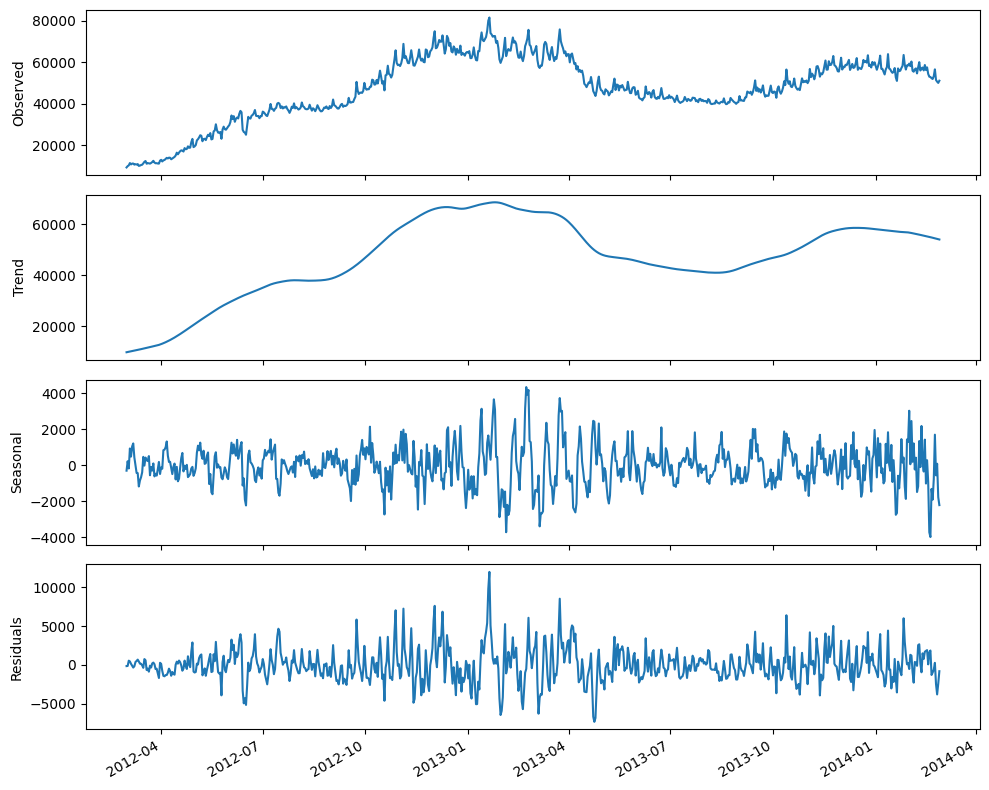

In [44]:
decomposition = STL(daily_usage['energy_sum'], period=30).fit()      
 
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(10,8))                                          
 
ax1.plot(decomposition.observed)
ax1.set_ylabel('Observed')
 
ax2.plot(decomposition.trend)
ax2.set_ylabel('Trend')
 
ax3.plot(decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(decomposition.resid)
ax4.set_ylabel('Residuals')
 
fig.autofmt_xdate()
plt.tight_layout()

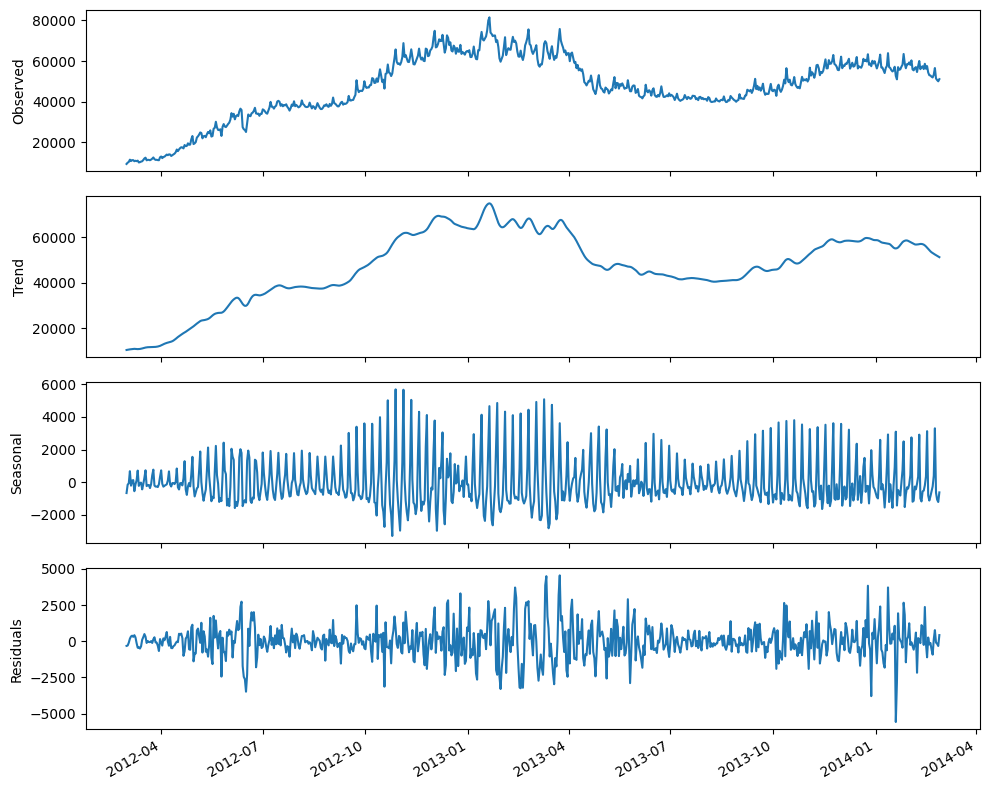

In [45]:
decomposition = STL(daily_usage['energy_sum'], period=7).fit()      
 
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(10,8))                                          
 
ax1.plot(decomposition.observed)
ax1.set_ylabel('Observed')
 
ax2.plot(decomposition.trend)
ax2.set_ylabel('Trend')
 
ax3.plot(decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(decomposition.resid)
ax4.set_ylabel('Residuals')
 
fig.autofmt_xdate()
plt.tight_layout()

In [46]:
train = daily_usage[:int(len(daily_usage) * .7)].copy()
test = daily_usage[int(len(daily_usage) * .7):].copy()

In [47]:
print("Training data length:", len(train))
print("Test data length:", len(test))

Training data length: 509
Test data length: 219


In [48]:
num_cols = daily_usage.shape[1] + 1
p_vals = range(1, 10, 1)                  
q_vals = range(1, 10, 1)                  
 
ARIMA_order_list = list(product(p_vals, q_vals))

In [49]:
def fit_eval_AIC(data, order_list, i_order):
    aic_results = []
    for o in order_list:
        model = SARIMAX(data['energy_sum'], order=(o[0], i_order, o[1]),
                        simple_differencing=False)
        res = model.fit(disp=False, maxiter=1000)
        aic = res.aic
        aic_results.append([o, aic])
        
    result_df = pd.DataFrame(aic_results, columns=(['(p, q)', 'AIC']))
    result_df.sort_values(by='AIC', ascending=True, inplace=True)
    result_df.reset_index(drop=True, inplace=True)
    
    return result_df

In [50]:
ARIMA_result_df = fit_eval_AIC(train.asfreq('D'), ARIMA_order_list, 1)
print(ARIMA_result_df)

/home/andre/anaconda3/envs/dva/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/home/andre/anaconda3/envs/dva/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/home/andre/anaconda3/envs/dva/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/home/andre/anaconda3/envs/dva/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/home/andre/anaconda3/envs/dva/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as sta

    (p, q)          AIC
0   (7, 7)  9128.798032
1   (8, 7)  9130.054595
2   (7, 8)  9130.128064
3   (9, 7)  9134.395075
4   (6, 8)  9136.327658
..     ...          ...
76  (1, 3)  9280.992859
77  (1, 4)  9281.079640
78  (3, 2)  9281.418513
79  (2, 3)  9282.911364
80  (1, 1)  9288.456453

[81 rows x 2 columns]


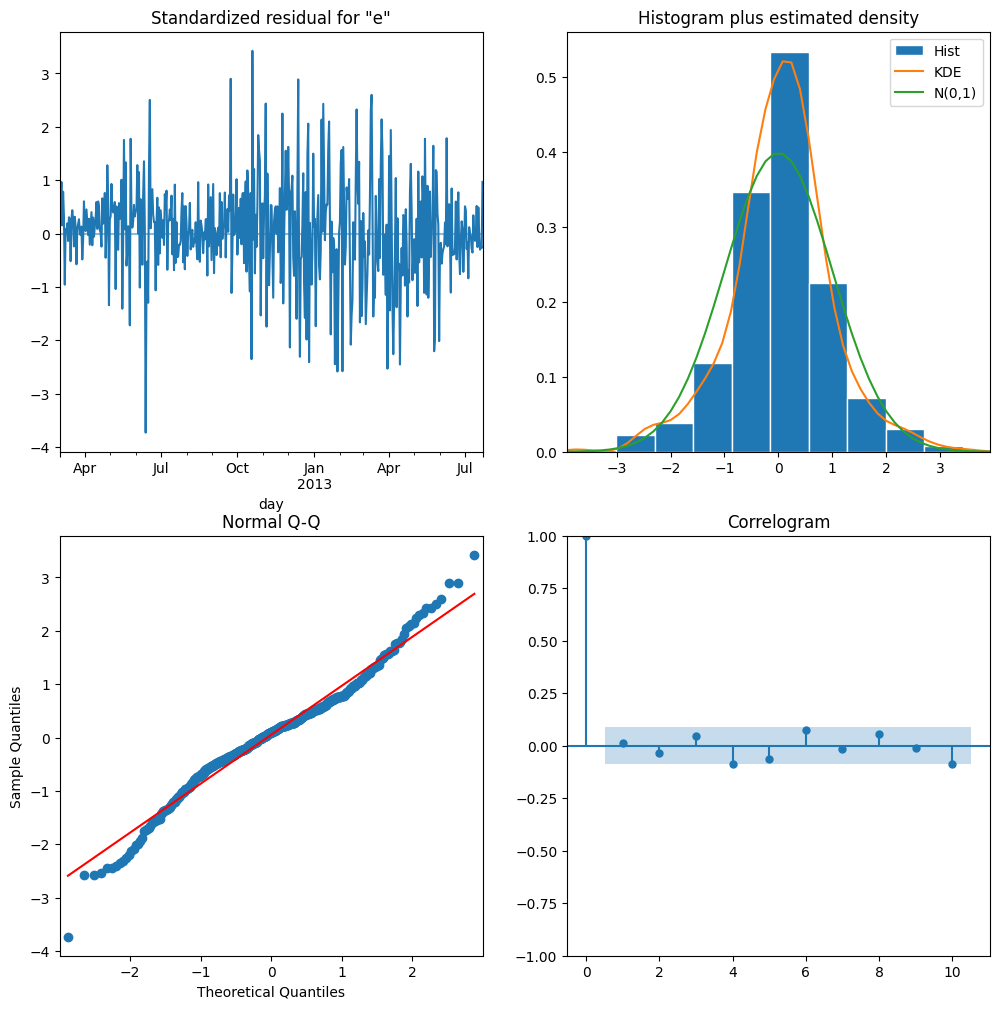

In [51]:
ARIMA_model = SARIMAX(train['energy_sum'].asfreq('D'), order=(7, 1, 7), simple_differencing=False)
ARIMA_model_fit = ARIMA_model.fit(disp=False, maxiter=1000) 
ARIMA_model_fit.plot_diagnostics(figsize=(12,12))
plt.show()

In [52]:

styled_df = test.head().to_html()
styled_df = f'<div style="overflow-x:auto;">{styled_df}</div>'
display(HTML(styled_df))

,energy_sum
day,
2013-07-23,42742.155999
2013-07-24,41246.891998
2013-07-25,41670.821996
2013-07-26,40784.940004
2013-07-27,42291.469002


In [53]:
test['naive_seasonal'] = train['energy_sum'].iloc[-1 * len(test):].values
test['pred_ARIMA'] = ARIMA_model_fit.get_prediction(len(train), len(daily_usage)).predicted_mean

stlf = STLForecast(train['energy_sum'].asfreq('D'),
                   ARIMA,
                   model_kwargs=dict(order=(7, 1, 7), trend="t"),
                   # seasonal=13,
                   # seasonal_jump=3,
                   # trend_jump=10,
                   # low_pass_jump=3,
                   period=30,
                   robust=True)
stlf_res = stlf.fit()
pred_STLARIMA = stlf_res.forecast(steps=len(test)+1)
test['pred_STLARIMA'] = pred_STLARIMA

styled_df = test.tail().to_html()
styled_df = f'<div style="overflow-x:auto;">{styled_df}</div>'
display(HTML(styled_df))

/home/andre/anaconda3/envs/dva/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



,energy_sum,naive_seasonal,pred_ARIMA,pred_STLARIMA
day,,,,
2014-02-23,56547.790995,41886.607002,43571.177857,56814.946436
2014-02-24,51432.588004,41435.730000,42401.879641,56489.512744
2014-02-25,50637.256001,41696.469997,42412.311630,55724.644901
2014-02-26,50046.742994,42938.096998,42835.175561,54927.540292
2014-02-27,51099.804998,42873.731994,41975.227021,55885.897718


In [54]:
def fit_eval_AIC_SARIMA(data, order_list, d, D, s):
    aic_results = []
    for o in order_list:
        model = SARIMAX(data, order=(o[0], d, o[1]),
                        seasonal_order = (o[2], D, o[3], s),
                        simple_differencing=False)
        res = model.fit(disp=False, maxiter=500)
        aic = res.aic
        aic_results.append([o, aic])
        
    result_df = pd.DataFrame(aic_results, columns=(['(p, q, P, Q)', 'AIC']))
    result_df.sort_values(by='AIC', ascending=True, inplace=True)
    result_df.reset_index(drop=True, inplace=True)
    
    return result_df

In [55]:
daily_usage_diff = np.diff(daily_usage['energy_sum'], n = 7)

ADF_result = adfuller(daily_usage_diff)     
print(f'ADF Statistic: {ADF_result[0]}')      
print(f'p-value: {ADF_result[1]}')   

ADF Statistic: -19.979189501873563
p-value: 0.0


In [56]:
ps = [5]
qs = [5]
Ps = range(1, 4, 1)
Qs = range(1, 4, 1)

SARIMA_order_list = list(product(ps, qs, Ps, Qs))

d = 1
D = 0
s = 7

SARIMA_result_df = fit_eval_AIC_SARIMA(train.asfreq('D'), SARIMA_order_list, d, D, s)
print(SARIMA_result_df)

/home/andre/anaconda3/envs/dva/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/home/andre/anaconda3/envs/dva/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/home/andre/anaconda3/envs/dva/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/home/andre/anaconda3/envs/dva/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



   (p, q, P, Q)          AIC
0  (5, 5, 2, 2)  9097.745849
1  (5, 5, 1, 2)  9100.556156
2  (5, 5, 1, 3)  9106.111387
3  (5, 5, 3, 2)  9109.362846
4  (5, 5, 2, 3)  9114.719452
5  (5, 5, 2, 1)  9114.797654
6  (5, 5, 1, 1)  9120.186360
7  (5, 5, 3, 1)  9123.060473
8  (5, 5, 3, 3)  9125.066414


/home/andre/anaconda3/envs/dva/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



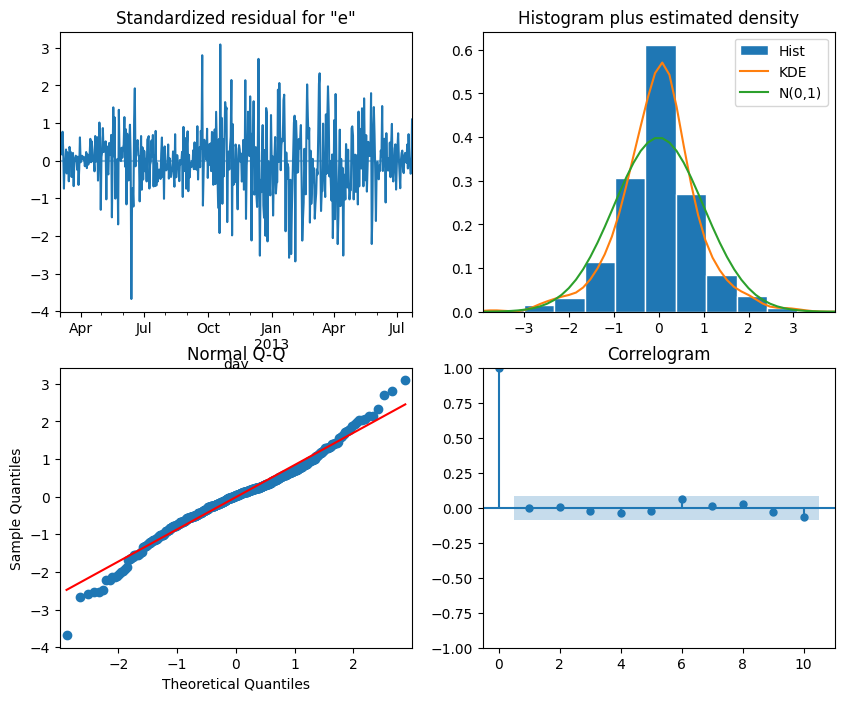

In [57]:
SARIMA_model = SARIMAX(train['energy_sum'].asfreq('D'), order=(5,1,5), seasonal_order=(1,0,1,7), simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False, maxiter=100)

SARIMA_model_fit.plot_diagnostics(figsize=(10,8))
plt.show()

In [58]:
SARIMA_pred = SARIMA_model_fit.get_prediction(len(train), len(daily_usage)).predicted_mean   
test['SARIMA_pred'] = SARIMA_pred

styled_df = test.head().to_html()
styled_df = f'<div style="overflow-x:auto;">{styled_df}</div>'
display(HTML(styled_df))

,energy_sum,naive_seasonal,pred_ARIMA,pred_STLARIMA,SARIMA_pred
day,,,,,
2013-07-23,42742.155999,69199.045997,42522.221022,45218.089469,41811.159152
2013-07-24,41246.891998,65160.360999,42574.773740,41807.325709,41569.818854
2013-07-25,41670.821996,64700.269998,42034.643300,39656.212529,41749.098908
2013-07-26,40784.940004,67570.420990,42194.976084,39396.181377,41844.701805
2013-07-27,42291.469002,66577.329999,42759.741119,42766.165299,42107.834139


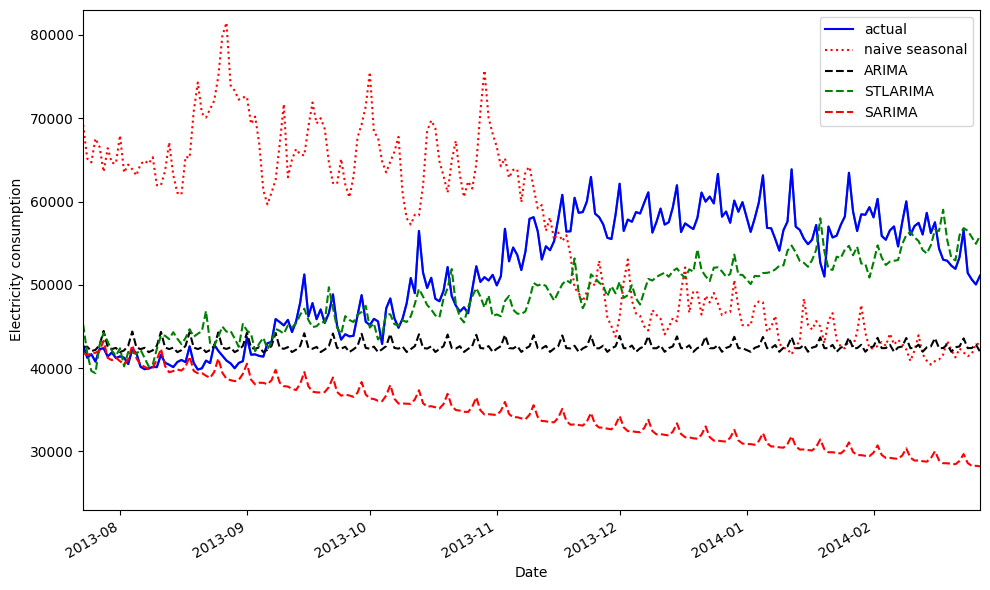

In [80]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(daily_usage['energy_sum'])
ax.plot(test['energy_sum'], 'b-', label='actual')
ax.plot(test['naive_seasonal'], 'r:', label='naive seasonal')
ax.plot(test['pred_ARIMA'], 'k--', label='ARIMA')
ax.plot(test['pred_STLARIMA'], 'g--', label='STLARIMA')
ax.plot(test['SARIMA_pred'], 'r--', label='SARIMA')

ax.set_xlabel('Date')
ax.set_ylabel('Electricity consumption')

ax.set_xlim(pd.to_datetime('2013-07-23'), test.index[-1])

ax.set_ylim(23000, 83000)
ax.legend(loc=1)
fig.autofmt_xdate()
plt.tight_layout()

In [81]:
mae_naive_seasonal = mean_absolute_error(test['energy_sum'], test['naive_seasonal'])
mae_ARIMA = mean_absolute_error(test['energy_sum'], test['pred_ARIMA'])
mae_SARIMA = mean_absolute_error(test['energy_sum'], test['SARIMA_pred']) 
mae_STLARIMA = mean_absolute_error(test['energy_sum'], test['pred_STLARIMA']) 

print("Mean absolute error, baseline:", mae_naive_seasonal)
print("Mean absolute error, ARIMA:", mae_ARIMA)
print("Mean absolute error, SARIMA:", mae_SARIMA)
print("Mean absolute error, STLARIMA:", mae_STLARIMA)

Mean absolute error, baseline: 16082.46843817945
Mean absolute error, ARIMA: 9264.970148688057
Mean absolute error, SARIMA: 16766.61168668016
Mean absolute error, STLARIMA: 4033.753022960465


In [82]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_naive_seasonal = mean_absolute_percentage_error(test['energy_sum'], test['naive_seasonal'])
mape_ARIMA = mean_absolute_percentage_error(test['energy_sum'], test['pred_ARIMA'])
mape_SARIMA = mean_absolute_percentage_error(test['energy_sum'], test['SARIMA_pred'])
mape_STLARIMA = mean_absolute_percentage_error(test['energy_sum'], test['pred_STLARIMA'])

print("Mean Absolute Percentage Error, baseline:", mape_naive_seasonal)
print("Mean Absolute Percentage Error, ARIMA:", mape_ARIMA)
print("Mean Absolute Percentage Error, SARIMA:", mape_SARIMA)
print("Mean Absolute Percentage Error, STLARIMA:", mape_STLARIMA)

Mean Absolute Percentage Error, baseline: 33.61776536398382
Mean Absolute Percentage Error, ARIMA: 16.736089642175045
Mean Absolute Percentage Error, SARIMA: 30.430989607903737
Mean Absolute Percentage Error, STLARIMA: 7.4287398962279525


In [83]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

acorn_mapping_reverse = {v: k for k, v in acorn_mapping.items()}

for i in range(17):
    acorn_name = acorn_mapping_reverse[i]
    cur_daily_usage = df.groupby(['Acorn', 'day'])['energy_sum'].sum().reset_index()
    cur_daily_usage = cur_daily_usage.loc[cur_daily_usage['Acorn'] == i]
    cur_daily_usage.set_index('day', inplace=True)
    cur_daily_usage.fillna(method='ffill', inplace=True)
    
    cur_train = cur_daily_usage[:int(len(cur_daily_usage) * .7)].copy()
    cur_test = cur_daily_usage[int(len(cur_daily_usage) * .7):].copy()

    cur_test['naive_seasonal'] = cur_train['energy_sum'].asfreq('D').iloc[-1 * len(cur_test):].values    
    
    cur_ARIMA = SARIMAX(cur_train['energy_sum'].asfreq('D'), order=(11, 1, 11), simple_differencing=False).fit(disp=False, maxiter=500)
    cur_test['pred_ARIMA'] = cur_ARIMA.get_prediction(len(cur_train), len(cur_daily_usage)).predicted_mean 

    cur_SARIMA = SARIMAX(cur_train['energy_sum'].asfreq('D'), order=(5,1,5), seasonal_order=(1,0,1,7), simple_differencing=False).fit(disp=False, maxiter=1000)
    cur_test['SARIMA_pred'] = cur_SARIMA.get_prediction(len(cur_train), len(cur_daily_usage)).predicted_mean

    cur_STL = STLForecast(cur_train['energy_sum'].asfreq('D'), ARIMA, model_kwargs=dict(order=(7, 1, 7), trend="t"), period=30, robust=True)
    cur_test['pred_STLARIMA'] = cur_STL.fit().forecast(steps=len(cur_test)+1)
    
    mae_naive_seasonal = mean_absolute_error(cur_test['energy_sum'], cur_test['naive_seasonal'])
    mae_ARIMA = mean_absolute_error(cur_test['energy_sum'], cur_test['pred_ARIMA'])
    
    mae_naive_seasonal = mean_absolute_error(cur_test['energy_sum'], cur_test['naive_seasonal'])
    mae_STLARIMA = mean_absolute_error(cur_test['energy_sum'], cur_test['pred_STLARIMA'])
    mae_ARIMA = mean_absolute_error(cur_test['energy_sum'], cur_test['pred_ARIMA'])
    mae_SARIMA = mean_absolute_error(cur_test['energy_sum'], cur_test['SARIMA_pred'])
    mape_naive_seasonal = mean_absolute_percentage_error(cur_test['energy_sum'], cur_test['naive_seasonal'])
    mape_ARIMA = mean_absolute_percentage_error(cur_test['energy_sum'], cur_test['pred_ARIMA'])
    mape_SARIMA = mean_absolute_percentage_error(cur_test['energy_sum'], cur_test['SARIMA_pred'])
    mape_STLARIMA = mean_absolute_percentage_error(cur_test['energy_sum'], cur_test['pred_STLARIMA'])    
    
    # print("Mean absolute error, baseline:", mae_naive_seasonal)
    # print("Mean absolute error, STLARIMA:", mae_STLARIMA)
    # print("Mean absolute error, ARIMA:", mae_ARIMA)
    # print("Mean absolute error, SARIMA:", mae_SARIMA)

    cur_train.to_csv(f'forecast/cur_train_{acorn_name}.csv')
    cur_test.to_csv(f'forecast/cur_test_{acorn_name}.csv')    

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=cur_daily_usage.index, y=cur_daily_usage['energy_sum'], mode='lines', name='Actual'))
    fig.add_trace(go.Scatter(x=cur_test.index, y=cur_test['naive_seasonal'], mode='lines', name='Naive Seasonal'))
    fig.add_trace(go.Scatter(x=cur_test.index, y=cur_test['pred_ARIMA'], mode='lines', name='ARIMA'))
    fig.add_trace(go.Scatter(x=cur_test.index, y=cur_test['SARIMA_pred'], mode='lines', name='SARIMA'))
    fig.add_trace(go.Scatter(x=cur_test.index, y=cur_test['pred_STLARIMA'], mode='lines', name='STLARIMA'))
    fig.update_layout(title=f'Forecast for Acorn {acorn_name}', xaxis_title='Date', yaxis_title='Electricity consumption')
    fig.write_html(f'forecast/forecast_{acorn_name}.html')

    with open(f'forecast/MAEs_{acorn_name}.txt', 'w') as f:
        f.write(f"Mean absolute error, baseline: {mae_naive_seasonal}\n")
        f.write(f"Mean absolute error, STLARIMA: {mae_STLARIMA}\n")
        f.write(f"Mean absolute error, ARIMA: {mae_ARIMA}\n")
        f.write(f"Mean absolute error, SARIMA: {mae_SARIMA}\n")
        f.write(f"Mean Absolute Percentage Error, baseline: {mape_naive_seasonal}\n")
        f.write(f"Mean Absolute Percentage Error, STLARIMA: {mape_STLARIMA}\n")
        f.write(f"Mean Absolute Percentage Error, ARIMA: {mape_ARIMA}\n")
        f.write(f"Mean Absolute Percentage Errorr, SARIMA: {mape_SARIMA}\n")

/tmp/ipykernel_1465766/521126150.py:11: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

/home/andre/anaconda3/envs/dva/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/home/andre/anaconda3/envs/dva/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/home/andre/anaconda3/envs/dva/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/tmp/ipykernel_1465766/521126150.py:11: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

/home/andre/anaconda3/envs/dva/lib/python3.11/site-